This analysis was performed succesfully in "CentOS Linux release 7.5.1804 (Core)". If you use different version of Linux or OS, you may need to adjust it accordingly and we are not responsible for any liability or error.

Other information and issue reporting, please refer to https://github.com/muharif/LiverAging_2022

## Init

In [1]:
%matplotlib inline
import pandas as pd
import rpy2,os,re, shutil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import copy
sns.set(font="Arial")
sns.set_style("white")
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from sklearn.decomposition import PCA as sklearnPCA
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pickle
from statannot import add_stat_annotation

#rpy2
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

from scipy.stats import zscore, spearmanr
from scipy.interpolate import interp1d
from statsmodels.sandbox.stats.multicomp import multipletests
import leidenalg
import igraph as ig
import gseapy as gp
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

/data/arifm2/miniconda3/envs/LiverAging_Analysis/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
class DESeq_Piano:
    def __init__(self,respath='.'):
        if respath=='.':
            print('Result Path is Not Defined, any result will be written in this directory')
            self.respath=respath
        elif os.path.isdir(respath):
            print('Result Path Exists, please be careful of overwriting')
            self.respath=respath
        else:
            print('Result Path Does Not Exists, creating new directory')
            os.mkdir(respath)
            self.respath=respath
        if os.path.isdir(respath+'/Figures'):
            pass
        else:
            os.mkdir(respath+'/Figures')
        self.__Init()

            
    def __Init(self):

        
        robjects.r('''
            library('DESeq2')
            library('piano')
            library('Biobase')
            library('snow')
            library('RColorBrewer')
            library('gplots')
            library('snowfall')
        ''')
        self.GSC_KEGG=None
        self.GSC_GO=None
        self.KEGG=None
        self.GO=None
        self.dds=None
        self.deseq_res=None
        self.conds=None
        self.count=None
        self.tpm=None

    def __check_dir(self,extrapath):
        if os.path.isdir('%s/%s/' % (self.respath,extrapath)):
            print('Path %s/%s/ exist, writing in the folder' % (self.respath,extrapath))
        else:
            print('Path %s/%s/ does not exist, making the folder to write the results' % (self.respath,extrapath))
            os.mkdir('%s/%s/' % (self.respath,extrapath))
            
    def DEseq(self,count_df=None,conds_series=None):
        if count_df is not None:
            self.count=count_df
        if conds_series is not None:
            self.conds=conds_series
        self.gene_names=count_df.index
        robjects.globalenv['conds']=np.array(self.conds)
        robjects.globalenv['subject']=np.array(self.conds.index)
        robjects.globalenv['count']=self.count.astype(int).values
        robjects.r('''
            conds=as.factor(conds)
            coldata <- data.frame(row.names=subject,conds)
            dds <- DESeqDataSetFromMatrix(countData=as.matrix(count),colData=coldata,design=~conds)
            dds <- DESeq(dds)
            print(resultsNames(dds))
            #baseMeanPerLvl <- sapply( levels(conds), function(lvl) rowMeans( counts(dds,normalized=TRUE)[,conds == lvl] ) )
            #conds2=colnames(baseMeanPerLvl)
            #gene_names=rownames(baseMeanPerLvl)

        ''')
        self.dds=robjects.globalenv['dds']
    
    def DEseq_Compare(self, cond1, cond2,save=True):
        if self.dds is None:
            raise ValueError('No DESeq data found, run the DEseq function')
        else:
            print('Comparing %s and %s' % (cond1,cond2))
            robjects.globalenv['dds']=self.dds
            robjects.globalenv['cond1']=cond1
            robjects.globalenv['cond2']=cond2
            robjects.globalenv['gene_names']=np.array(self.gene_names)
            robjects.r('''
                res=results(dds,contrast=c('conds',cond1,cond2))
                res=data.frame(res)
                res$rownames=gene_names
            ''')
            res = pd.DataFrame(robjects.globalenv['res']).set_index('rownames')
            self.deseq_df=res
            if save:
                self.__check_dir('deseq')
                res.to_csv('%s/deseq/deseq_%s_%s.txt' % (self.respath,cond1,cond2),sep='\t')
        
    def loadGSC(self,KEGG='',TF='',RM='',GO='',extraGSC=''):
        if KEGG != '':
            name='KEGG'
            self.__check_dir(name)
            self.GSC_KEGG=self.__loadGSC_execute(KEGG)
        if GO != '':
            name='GO'
            self.__check_dir(name)
            self.GSC_GO=self.__loadGSC_execute(GO)

    
    def __loadGSC_execute(self,GSC):
        robjects.globalenv['GSC']=GSC 
        robjects.r('''
            y=loadGSC(GSC)
        ''')
        return robjects.globalenv['y']
    
    def __PIANO_execute(self,cond1,cond2,GSCtype='',save=True):
        robjects.globalenv['deseq_file']=pandas2ri.py2rpy_pandasdataframe(self.deseq_df)
        if GSCtype == 'KEGG':
            robjects.globalenv['y']=self.GSC_KEGG
            deseq_df=self.deseq_df
            robjects.globalenv['deseq_file']=pandas2ri.py2rpy_pandasdataframe(deseq_df)
        elif GSCtype == 'GO':
            robjects.globalenv['y']=self.GSC_GO
            deseq_df=self.deseq_df
            deseq_df.index=[i.upper() for i in deseq_df.index]
            robjects.globalenv['deseq_file']=pandas2ri.py2rpy_pandasdataframe(deseq_df)
        robjects.r('''
            DESeq_file=deseq_file
            DESeq_file=DESeq_file[ ,c('log2FoldChange','pvalue')]
            logFC=as.matrix(DESeq_file[,1])
            pval=as.matrix(DESeq_file[,2])
            rownames(logFC)=(rownames(DESeq_file))
            rownames(pval)=(rownames(DESeq_file))
            logFC[is.na(logFC)] <- 0
            pval[is.na(pval)] <- 1
            gsaRes <- runGSA(pval,logFC,gsc=y, geneSetStat="reporter", signifMethod="nullDist", nPerm=1000,ncpus=8,gsSizeLim = c(5, Inf))
            res_piano=GSAsummaryTable(gsaRes)
            res_piano$rownames=rownames(res_piano)
        ''')
        res=pd.DataFrame(robjects.globalenv['res_piano']).set_index('rownames').set_index('Name').iloc[0:,0:]#.groupby('Name').sum()
        if save:
            res.to_csv('%s/%s/piano_%s_%s.txt' % (self.respath,GSCtype,cond1,cond2),sep='\t')
        return res

    
    def PIANO(self,cond1,cond2,heatmap=True,save=True):
        if save:
            self.__check_dir('Figures')
        if self.deseq_df is None:
            raise ValueError('No DEseq comparison found, run DEseq_Compare first or assign deseq result dataframe to deseq_res')
        else:
            if self.GSC_KEGG is not None:
                name='KEGG'
                self.KEGG = self.__PIANO_execute(cond1,cond2,GSCtype=name,save=save)
            if self.GSC_GO is not None:
                name='GO'
                self.GO = self.__PIANO_execute(cond1,cond2,GSCtype=name,save=save)       
                    
    def __piano2xlsx(self,name,part='ALL'):
        if part != 'ALL':
            files=[i for i in sorted(os.listdir('%s/%s' % (self.respath,name))) if part in i]
        else:
            files=sorted(os.listdir('%s/%s' % (self.respath,name)))
        writer = pd.ExcelWriter('%s/%s_%s.xlsx' % (self.respath,name,part), engine='xlsxwriter')
        for i in files:
            if i.startswith('.'):
                continue
            deseq1=pd.read_csv('%s/%s/%s' % (self.respath,name,i),index_col='Name',sep='\t')[['Genes (tot)','Stat (dist.dir.up)','p adj (dist.dir.up)']]
            deseq1.columns=['# of Genes', 'Stats','P-Adj']
            deseq1=deseq1[deseq1['P-Adj']<0.05]
            deseq1['Direction']='UP'
            deseq2=pd.read_csv('%s/%s/%s' % (self.respath,name,i),index_col='Name',sep='\t')[['Genes (tot)','Stat (dist.dir.up)','p adj (dist.dir.dn)']]
            deseq2.columns=['# of Genes', 'Stats','P-Adj']
            deseq2=deseq2[deseq2['P-Adj']<0.05]
            deseq2['Direction']='DOWN'
            deseq1=pd.concat([deseq1,deseq2])
            if len(i.replace('piano_','').replace('.txt',''))>31:
                print('sheet name too big, trimming to 30 character')
                n_temp=i.replace('piano_','').replace('.txt','')[0:31]
            else:
                n_temp=i.replace('piano_','').replace('.txt','')
            deseq1.sort_values('P-Adj').to_excel(writer, sheet_name=n_temp)
        writer.save()
        
    def summarizePiano(self,names=['KEGG','GO','TF','RM','extraGSC'],part='ALL'):
        for name in names:
            if os.path.isdir(self.respath+name):
                self.__piano2xlsx(name,part=part)
            else:
                continue
    
    def summarizeDEseq(self,deseq_result='deseq',part='ALL'):
        if os.path.isdir(self.respath+deseq_result):
            if part != 'ALL':
                files=[i for i in sorted(os.listdir(self.respath+'/deseq/')) if part in i]
            else:
                files=sorted(os.listdir(self.respath+'/deseq/'))
            writer = pd.ExcelWriter(self.respath+'/DifferentialExpression_%s.xlsx' % part, engine='xlsxwriter')
            fin=0
            for i in files:
                if i.startswith('.'):
                    continue
                deseq=pd.read_csv(self.respath+'/deseq/%s' % i,index_col=0,sep='\t')
                deseq['abs']=deseq['log2FoldChange'].abs()
                deseq=deseq.sort_values('abs',ascending=False)[['log2FoldChange','pvalue','padj']]

                deseq['Direction']=['UP' if i > 0 else 'DOWN' for i in deseq['log2FoldChange']]
                deseq.columns=['L2FC','P-VALUE','P-ADJ','DIRECTION']
                deseq=deseq.sort_values('P-VALUE')
                if len(i.replace('deseq_','').replace('.txt',''))>31:
                    print('sheet name too big, trimming to 30 character')
                    n_temp=i.replace('deseq_','').replace('.txt','')[0:31]
                else:
                    n_temp=i.replace('deseq_','').replace('.txt','')
                deseq.to_excel(writer, sheet_name=n_temp)
            writer.save()
        else:
            raise ValueError('No DESEq result found')

    def save_object(self,filename='DEseq_PIANO.pkl'):
        with open('%s/%s' % (self.respath,filename), 'wb') as file:
            pickle.dump(self, file)
    
    def load_object(self,filename='DEseq_PIANO.pkl'):
        with open(filename, 'rb') as file:
            res=pickle.load(file)
        return res

def calc(tpm,pval_thr=0.05,pos_only=False):
    print('Calculating Correlation..')
    temp=spearmanr(tpm.T)
    corr=pd.DataFrame(temp[0],columns=list(tpm.index),index=list(tpm.index))
    pval=pd.DataFrame(temp[1],columns=list(tpm.index),index=list(tpm.index))
    print('Filtering the matrix Correlation..')
    corr=corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
    pval=pval.where(np.triu(np.ones(pval.shape)).astype(np.bool))
    print('Making long table of Correlation..')
    corr2=corr.unstack().reset_index(name='weight')
    pval2=pval.unstack().reset_index(name='pval')
    res=corr2.merge(pval2,on=['level_0','level_1'])
    res=res[res['level_0'] != res['level_1']]
    res=res.dropna()
    print('Adjusting P-val')
    res['padj']=multipletests(res['pval'],method='fdr_bh')[1]
    res=res[res.padj < pval_thr].reset_index(drop=True)
    if pos_only:
        res=res[res['weight']>0]
    res=res[['level_0','level_1','weight']]
    print('Done!!')
    return res
def filter_fpkm(fpkm,conds,thr=1):
    return fpkm[(pd.concat([fpkm.T,conds],1).groupby(conds.name).mean().T>thr).sum(1)>0]

class Network_Analysis:
    def __init__(self,filename,respath,KEGG='',GO='',topx=0.05,cluster_size=30):
        self.network_ori=pd.read_csv(filename,sep='\t')
        self.res_path=respath
        if os.path.isdir(self.res_path):
            pass
        else:
            os.mkdir(self.res_path)
        self.cluster_size=cluster_size
        self.topx=topx
        self.GSC_KEGG=KEGG
        self.GSC_GO=GO
        self.__net_analysis()
        self.export_cluster_cytoscape()
        print('Enriching Clusters...')
        self.__cluster_enrichr()
        
    def __net_analysis(self):
        print('Loading The Network...')
        temp=self.network_ori[self.network_ori['weight']>0]
        temp=temp[temp['weight']>temp['weight'].quantile(1-self.topx)]
        g= ig.Graph.TupleList(zip(temp['level_0'],temp['level_1']))
        print('Cluster Analysis...')
        pd.Series(g.degree(), index = g.vs['name']).sort_values(ascending = False).to_csv('%s/degree_pos.txt' % self.res_path,sep='\t')
        optimiser = leidenalg.Optimiser()
        clust_calc = leidenalg.ModularityVertexPartition(g)
        diff =  optimiser.optimise_partition(clust_calc, n_iterations=-1)
        clust=pd.Series(clust_calc.membership,index=g.vs['name'])
        thr=self.cluster_size
        temp_c=clust.value_counts()[clust.value_counts()>thr].index.tolist()
        self.clustering=clust[clust.isin(temp_c)]
        self.modularity=clust_calc.modularity
        self.network=g
        
    def __enrichr(self,GSC,db_name):
        final={}
        for i in range(self.clustering.value_counts().shape[0]):
            if db_name == 'GO':
                gene_list=list([i.upper() for i in self.clustering[self.clustering.isin([i])].index])
            else:
                gene_list=list([i for i in self.clustering[self.clustering.isin([i])].index])
            enr = gp.enrichr(gene_list=gene_list,
                             description='test_name',
                             gene_sets=GSC,
                             background=20000,
                             outdir='test/enrichr_kegg2',
                             cutoff=0.5,
                             verbose=False)
            
            try:
                temp=enr.res2d[enr.res2d['Adjusted P-value']<0.05].sort_values('Adjusted P-value')[['Term','Adjusted P-value']]
                temp.columns=['%s' % db_name,'P-Adj (%s)' % db_name]
                if db_name == 'GO':
                    temp['GOID']=[s[s.find("(")+1:s.find(")")] for s in temp['GO']]
                    temp=temp[['GO','GOID','P-Adj (GO)']]
            except TypeError:
                temp = pd.DataFrame(columns = ['Term','Adjusted P-value'])
                if db_name == 'GO':
                    temp = pd.DataFrame(columns = ['GO','GOID','P-Adj (GO)'])
            final[i]=temp.reset_index(drop=True)
        return final
    
    def __cluster_enrichr(self):
        if (self.GSC_KEGG != '') | (self.GSC_GO != ''):
            writer = pd.ExcelWriter('%s/Coexp_Cluste_Enrichr.xlsx' % self.res_path, engine='xlsxwriter')
            if self.GSC_KEGG != '':
                self.KEGG=self.__enrichr(self.GSC_KEGG,'KEGG')
                pd.concat(self.KEGG.values(), axis=1, keys=self.KEGG.keys()).to_excel(writer, sheet_name='KEGG')

            if self.GSC_GO != '':
                self.GO=self.__enrichr(self.GSC_GO,'GO')
                pd.concat(self.GO.values(), axis=1, keys=self.GO.keys()).to_excel(writer, sheet_name='GO')

            if (self.GSC_KEGG != '') & (self.GSC_GO != ''):
                self.Both={i:pd.concat([self.GO[i],self.KEGG[i]],1) for i in range(self.clustering.value_counts().shape[0])}
                pd.concat(self.Both.values(), axis=1, keys=self.Both.keys()).to_excel(writer, sheet_name='Both')
            writer.save()
            shutil.rmtree('test')
    
    def save_network(self):
        pickle_out = open('%s/network_object.pkl' % self.res_path,"wb")
        pickle.dump(self, pickle_out)
        pickle_out.close()
        
    def export_cluster_cytoscape(self):
        temp=self.network_ori.merge(pd.DataFrame(self.clustering).reset_index(),how='left',left_on='level_0',right_on='index').merge(pd.DataFrame(self.clustering).reset_index(),how='left',left_on='level_1',right_on='index').dropna()
        temp2=temp[['0_x','0_y']]
        temp2['count']=1
        temp2=temp2.groupby(['0_x','0_y']).count().reset_index().pivot_table(index='0_x',columns='0_y',values='count').fillna(0)
        temp2=pd.DataFrame([(i,j,(temp2.loc[i,j]+temp2.loc[j,i]),(temp2.loc[i,j]+temp2.loc[j,i])/(self.clustering.value_counts()[i]+self.clustering.value_counts()[j])) for i in temp2.index for j in temp2.columns if (i < j)],columns=['Source','Target','Weight1','Weight2'])
        temp2.astype(int).to_csv('%s/edge_pos_cluster.txt' % self.res_path,sep='\t')
        pd.DataFrame(self.clustering.value_counts(),columns=['Size']).to_csv('%s/node_pos_cluster.txt' % self.res_path,sep='\t')
        self.clustering.to_csv('%s/clust_pos_cluster.txt' % self.res_path,sep='\t')

## Data Loading

In [88]:
conds=pd.read_csv('../Data/Result_X202SC21050892-Z01-F001_Rattus_norvegicus/3.Quantification/Count/conds.txt',sep='\t',index_col = 0)
conds=conds['conds']
# conds = conds[conds.str.contains('A')]
conds = conds[~conds.index.isin(['LAP2', 'LAP6'])]
count=pd.read_csv('../Data/Result_X202SC21050892-Z01-F001_Rattus_norvegicus/3.Quantification/Count/readcount_genename.xls',sep='\t',index_col = 0)
count=count[count['gene_biotype'] == 'protein_coding'].iloc[0:,0:-8].groupby('gene_name').sum()[conds.index]
fpkm=pd.read_csv('../Data/Result_X202SC21050892-Z01-F001_Rattus_norvegicus/3.Quantification/Count/fpkm_genename.xls',sep='\t',index_col = 0)
fpkm=fpkm[fpkm['gene_biotype'] == 'protein_coding'].iloc[0:,0:-8].groupby('gene_name').sum()[conds.index]

In [89]:
temp.sort_values(['conds', 'Ldlr'])

,0610010F05Rik,1110034G24Rik,1700021K19Rik,2310007L24Rik,2310067B10Rik,2900026A02Rik,3110040N11Rik,4930562C15Rik,5330417C22Rik,A1cf,...,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6,mrpl11,mrpl24,mrpl9,rnf141,ste2
conds,,,,,,,,,,,,,,,,,,,,,
A,NaN,1.957225,2.141931,1.474063,4.438055,8.756655,1.629017,1.695902,4.218137,5.282096,...,1.066066,24.965032,1.505083,1.913005,8.707450,32.260061,18.361324,15.951189,13.602620,174.771408
AT,1.179408,1.830052,2.114612,1.961143,4.957024,7.740638,1.505811,1.921893,4.422320,4.495514,...,1.110322,24.455377,1.763733,1.583666,8.152039,29.935498,15.556242,17.430930,11.866942,276.765191


/data/arifm2/miniconda3/envs/LiverAging_Analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='conds', ylabel='Ldlr'>

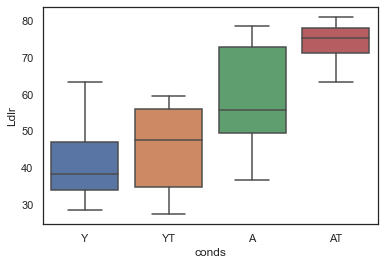

In [90]:
temp = pd.concat([fpkm.loc['Ldlr'], conds],1)
sns.boxplot(data = temp, x = 'conds', y = 'Ldlr')

## PCA (Figure 1B)

In [91]:
temp = pd.concat([fpkm.T,conds],1).groupby('conds').median()
temp = temp[temp>1].dropna(how='all',axis = 1)
sub = fpkm.reindex(set(temp.columns)).dropna()
sub.shape

/data/arifm2/miniconda3/envs/LiverAging_Analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


(10076, 22)

In [92]:
coordinate.sort_values('x')

,index,x,y,conds
5,LA6,-15.752872,0.351277,A
3,LA4,-13.010961,7.584934,A
8,LAP4,-6.115709,-3.732673,AT
2,LA3,-5.926672,-3.045928,A
1,LA2,1.220395,-9.212390,A
4,LA5,1.319342,-10.841258,A
6,LAP1,1.868866,-2.751230,AT
7,LAP3,4.992626,17.160534,AT
9,LAP5,11.533276,9.690872,AT
0,LA1,19.871709,-5.204138,A


/data/arifm2/miniconda3/envs/LiverAging_Analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


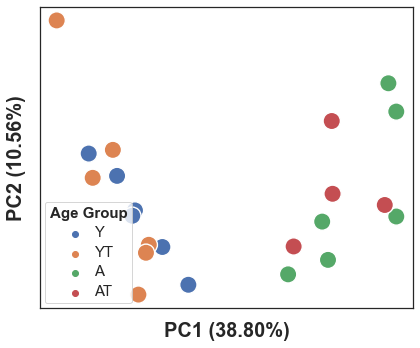

In [93]:
var = 'conds'
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(np.log1p(sub.T))
plt.figure(figsize=(6,5))
coordinate = pd.DataFrame(Y_sklearn, columns = ['x', 'y'], index = conds.index)
coordinate = pd.concat([coordinate, conds],1).reset_index()
ax = sns.scatterplot(data = coordinate, x = 'x', y = 'y', s = 300, hue = 'conds')
ax.set_xlabel('PC1 (%.2f%%)' % (sklearn_pca.explained_variance_ratio_[0]*100), fontsize = 20, fontweight = 'bold')
ax.set_ylabel('PC2 (%.2f%%)' % (sklearn_pca.explained_variance_ratio_[1]*100), fontsize = 20, fontweight = 'bold')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_legend().set_title('Age Group')
plt.setp(ax.get_legend().get_title(), fontsize='15', fontweight = 'bold')
plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.tight_layout()
# plt.savefig('Figures/1B.pdf')

## Differential Expression Analysis
The results of this analysis are under the folder in res_path. THis is associated with DEG, GO, and KEGG in Supplementary Table 1

In [94]:
res_path='../Results_Treatment/'
k=DESeq_Piano(res_path)
k.DEseq(count,conds)
k.loadGSC(KEGG='lib/KEGG_rat_Novogene.gmt', GO='lib/GO_Biological_Process_2021.gmt')

Result Path Exists, please be careful of overwriting


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "Intercept"     "conds_AT_vs_A" "conds_Y_vs_A"  "conds_YT_vs_A"
Path ../Results_Treatment//KEGG/ exist, writing in the folder
Path ../Results_Treatment//GO/ exist, writing in the folder


In [95]:
cond1='AT'
cond2='A'
k.DEseq_Compare(cond1,cond2,save=True)
k.PIANO(cond1,cond2,heatmap=False,save=True)

k.summarizeDEseq()
k.summarizePiano()

Comparing AT and A
Path ../Results_Treatment//deseq/ exist, writing in the folder
Path ../Results_Treatment//Figures/ exist, writing in the folder


R[write to console]: Running gene set analysis:



Checking arguments...done!


R[write to console]: Final gene/gene-set association: 7255 genes and 333 gene sets

R[write to console]:   Details:

R[write to console]:   Calculating gene set statistics from 7255 out of 21941 gene-level statistics

R[write to console]:   Removed 832 genes from GSC due to lack of matching gene statistics

R[write to console]:   Removed 0 gene sets containing no genes after gene removal

R[write to console]:   Removed additionally 6 gene sets not matching the size limits

R[write to console]:   Loaded additional information for 333 gene sets



Calculating gene set statistics...done!
Calculating gene set significance...done!
Adjusting for multiple testing...done!


R[write to console]: Running gene set analysis:



Checking arguments...done!


R[write to console]: Final gene/gene-set association: 12474 genes and 5763 gene sets

R[write to console]:   Details:

R[write to console]:   Calculating gene set statistics from 12474 out of 21941 gene-level statistics

R[write to console]:   Removed 2458 genes from GSC due to lack of matching gene statistics

R[write to console]:   Removed 4 gene sets containing no genes after gene removal

R[write to console]:   Removed additionally 269 gene sets not matching the size limits

R[write to console]:   Loaded additional information for 5763 gene sets



Calculating gene set statistics...done!
Calculating gene set significance...done!
Adjusting for multiple testing...done!


## Figure 1C

In [ ]:
temp = pd.ExcelFile('DiffExp_FunctionalAnalysis/DifferentialExpression_ALL.xlsx')
res = []
for i in temp.sheet_names[0:]:
    ha = temp.parse(i, index_col = 0)
    ha = ha[ha['P-ADJ'] < 0.05]['DIRECTION']
    res.append(ha.rename(i.replace('_', ' vs ')))
res = pd.concat(res, 1)
temp2 = res.unstack().reset_index().dropna().groupby(['level_0',0]).count().reset_index()

In [ ]:
res.shape

In [ ]:
plt.figure(figsize = (2,4))
g = sns.barplot(data = temp2, x = 0, y = 'rownames', order = ['UP', 'DOWN'], palette = ["#a50000", "#0000a5"])
# g.set_yticklabels(g.get_yticklabels(), fontsize = 10)
g.set_xticklabels(g.get_xticklabels(), fontsize = 15, fontweight = 'bold')
g.set_xlabel('')
g.set_ylabel('')
plt.tight_layout()
plt.savefig('Figures/1C.pdf')

## Figure 1D & 2F

In [ ]:
temp = pd.ExcelFile('DiffExp_FunctionalAnalysis/GO_ALL.xlsx')
res = []
for i in temp.sheet_names:
    ha = temp.parse(i, index_col = 0)
    ha_up = ha[ha['Stats'] > 0]
    ha_up = ha_up.replace(0, ha_up[ha_up['P-Adj'] > 0]['P-Adj'].min()*0.01)
    ha_dn = ha[ha['Stats'] < 0]
    ha_dn = ha_dn.replace(0, ha_dn[ha_dn['P-Adj'] > 0]['P-Adj'].min()*0.01)
    ha = pd.concat([ha_up, ha_dn])
    ha[i.replace('_', ' vs ')] = (-np.log10(ha['P-Adj'])*np.sign(ha['Stats']))
    res.append(ha[i.replace('_', ' vs ')])
res = pd.concat(res, 1)

In [ ]:
res_sel = res[res.index.str.contains('mitoch')].reset_index()
res_sel['Name'] = [i.split(' (GO')[0].replace('mitochondrial', 'MT').replace('electron transport', 'ET').replace('respiratory chain', 'RC') for i in res_sel['Name']]
plt.figure(figsize = (2, 4))
ax = sns.barplot(data = res_sel, x = 'Aging vs Young', y = 'Name', color = "#0000a5")
ax.set_ylabel('')
ax.set_xlabel('Gene-Level Statistics', fontsize = 20, fontweight = 'bold')
ax.vlines(0, ymin = ax.get_ylim()[1], ymax = ax.get_ylim()[0], color = 'k')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15, )
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
plt.savefig('Figures/1D.pdf')

In [ ]:
res_sel = res[res.index.str.contains('fatty') | res.index.str.contains('lipopro') | res.index.str.contains('chylomic') | res.index.str.contains('lipid ')].reset_index()
res_sel = res_sel[~res_sel['Name'].str.contains('negative') & ~res_sel['Name'].str.contains('positive')]
res_sel['Name'] = [i.split(' (GO')[0].replace('fatty acid', 'FA').replace('very-low-density lipoprotein', 'vLDL').replace('low-density lipoprotein', 'LDL').replace('high-density lipoprotein', 'HDL').replace('triglyceride', 'TG') for i in res_sel['Name']]
res_sel = res_sel.reindex([2, 3, 6, 9, 11, 13, 14, 16, 19]).sort_values('Aging vs Young') # Selecting to include just the upper level of GO

plt.figure(figsize = (4, 3))
ax = sns.barplot(data = res_sel, x = 'Aging vs Young', y = 'Name', color = "#0000a5")
ax.set_ylabel('')
ax.set_xlabel('Gene-Level Statistics', fontsize = 20, fontweight = 'bold')
ax.vlines(0, ymin = ax.get_ylim()[1], ymax = ax.get_ylim()[0], color = 'k')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15, )
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
plt.savefig('Figures/2F.pdf')

## Figure 1E and 2A-E
Generating the figures, then post-processing was done using graphic software

In [ ]:
# Excluding the unrelated diseases and pathways
exclude_KEGG = ['Hepatitis B', 'Human T-cell leukemia virus 1 infection', 'Regulation of actin cytoskeleton', 'Measles',
           'MicroRNAs in cancer', 'Pathways in cancer', 'Influenza A', 'Oocyte meiosis', 'Progesterone-mediated oocyte maturation',
           'Ribosome biogenesis in eukaryotes', 'Amoebiasis', 'Small cell lung cancer', 'Epstein-Barr virus infection', 'Human papillomavirus infection',
           'Pertussis', 'Staphylococcus aureus infection', 'Proteoglycans in cancer', 'Leishmaniasis', 'Legionellosis', 'Viral carcinogenesis', 
           'Chagas disease (American trypanosomiasis)', 'Toxoplasmosis', 'Malaria', 'Metabolism of xenobiotics by cytochrome P450', 'Chronic myeloid leukemia',
           'Prion diseases', 'Inflammatory bowel disease (IBD)', 'Kaposi sarcoma-associated herpesvirus infection', 'Parkinson disease', 'Hepatitis C', 'Systemic lupus erythematosus',
           'Tuberculosis', 'Hepatitis B', 'Measles', 'Dilated cardiomyopathy (DCM)', 'Hematopoietic cell lineage', 'Adrenergic signaling in cardiomyocytes',
           'Epstein-Barr virus infection', 'Drug metabolism', 'Salivary secretion', 'Thermogenesis', 'Glioma', 'Human cytomegalovirus infection', 'Melanoma', 'Chemical carcinogenesis',
            'African trypanosomiasis', 'Collecting duct acid secretion', 'African trypanosomiasis', 'Vascular smooth muscle contraction', 'Fluid shear stress and atherosclerosis',
            'Rheumatoid arthritis', 'Metabolic pathways', 'Spinocerebellar ataxia', 'Drug metabolism - other enzymes', 'Asthma'
          ]

In [ ]:
temp = open('lib/ko00001.keg', 'r').readlines()
x = []
for i in temp:
    if i.startswith('A'):
        A = ' '.join(i.split(' ')[1:]).rstrip('\n')
    if i.startswith('B  '):
        B = ' '.join(i.replace('B  ', '').split(' ')[1:]).rstrip('\n')
    if i.startswith('C    '):
        C = ' '.join(i.replace('C    ', '').split(' ')[1:]).split(' [PATH')[0].rstrip('\n')
        x.append([A, B, C])
x = pd.DataFrame(x, columns = ['A', 'B', 'C'])

In [ ]:
temp = pd.ExcelFile('DiffExp_FunctionalAnalysis/KEGG_ALL.xlsx')
res = []
for i in temp.sheet_names:
    ha = temp.parse(i, index_col = 0)
    ha_up = ha[ha['Stats'] > 0]
    ha_up = ha_up.replace(0, ha_up[ha_up['P-Adj'] > 0]['P-Adj'].min()*0.01)
    ha_dn = ha[ha['Stats'] < 0]
    ha_dn = ha_dn.replace(0, ha_dn[ha_dn['P-Adj'] > 0]['P-Adj'].min()*0.01)
    ha = pd.concat([ha_up, ha_dn])
    ha[i.replace('_', ' vs ')] = (-np.log10(ha['P-Adj'])*np.sign(ha['Stats']))
    res.append(ha[i.replace('_', ' vs ')])
res = pd.concat(res, 1)
# Excluding the unrelated diseases and pathways
res = res[~(res.index.str.contains('isease') | res.index.str.contains('nfection') | res.index.str.contains('ancer')| res.index.str.contains('epatitis')
           | res.index.str.contains('ardio') | res.index.str.contains('Malaria')  | res.index.str.contains('Gastric')  | res.index.str.contains('Influenza')
            | res.index.str.contains('Leishmaniasis') | res.index.str.contains('cleros') 
            | res.index.isin(exclude_KEGG)
           )]

In [ ]:
var = 'Aging vs Young'
temp = res[var].rename('Gene Level Statistics').dropna().sort_values().reset_index()
temp['Dir'] = ['#0000a5' if i < 0 else '#a50000' for i in temp['Gene Level Statistics']]
temp = temp.merge(x, left_on = 'Name', right_on = 'C').sort_values(['A', 'B', 'Gene Level Statistics'])
N = len(temp['B'].unique())
color_mapping = dict(zip(sorted(temp['B'].unique()),plt.get_cmap('gist_rainbow')(np.linspace(0,1,N))))
temp['col'] = [color_mapping[i] for i in temp['B']]

heights = [temp[temp['B'] == i].shape[0] for i in temp['B'].unique()]
fig, ax = plt.subplots(nrows=N, ncols=1, figsize = (4, 40), sharex = True,
                       gridspec_kw={
                           'height_ratios': heights,
                       'wspace': 0.4,
                       'hspace': 0.4})


for row,i in enumerate(temp['B'].unique()):
    print(i)
    temp2 = temp[temp['B'] == i]
    temp2['Name'] = temp2['Name'].str.replace(' pathway', '')
    sns.barplot(data = temp2, y = 'Name', x = 'Gene Level Statistics', palette = temp2['Dir'], ax = ax[row])
    ax[row].set_title(i, fontsize = 15, fontweight = 'bold')
    ax[row].set_ylabel('')
    ax[row].vlines(0, ymin = ax[row].get_ylim()[1], ymax = ax[row].get_ylim()[0], color = 'k')
#     ax[row].set_xticklabels(ax[row].get_xticklabels(), fontsize = 15, fontweight = 'bold')
    ax[row].set_yticklabels(ax[row].get_yticklabels(), fontsize = 15, )
    if row != (len(temp['B'].unique()) - 1):
        ax[row].set_xlabel('')
        sns.despine(ax=ax[row], top=True, right=True, left=True, bottom=True)
    else:
        sns.despine(ax=ax[row], top=True, right=True, left=True, bottom=False)
plt.tight_layout()
plt.savefig('Figures/KEGG_1E_2A-E.pdf')

## Figure 1F-H, 1J, and 4D

In [ ]:
var_name = {
    'CI': '1F',
    'CII': '1G',
    'CIV': '1H',
    'NAD': '1J',
    'TotalCholesterol': '4D',
}

for var in list(var_name.keys())[0:-1]:
    plt.figure(figsize = (2.5,4))
    fc = pd.concat([experimental[var]/experimental[experimental['Age'] == 'Y'][var].mean(), experimental['Age']],1)
    order = ['Y', 'A']
    box_pairs = [
        ('Y', 'A'),
    ]
    g = sns.barplot(data = fc, x = 'Age', y = var, order=order, palette = ['white', '#a50000'], capsize=.2,  edgecolor='black')#, hue = 'Gender', hue_order = hue_order)#, ax = axs[num])
    sns.stripplot(data = fc[fc['Age'] == 'Y'], x = 'Age', y = var, order=order, marker = 'o', color = 'black', alpha = 0.75)#, dodge = False, hue = 'Gender', hue_order = hue_order)#, ax = axs[num])
    sns.stripplot(data = fc[fc['Age'] == 'A'], x = 'Age', y = var, order=order, marker = 's', color = 'black', alpha = 0.75)
    add_stat_annotation(data = fc, x = 'Age', y = var, order=order, ax = g,#, hue_order = hue_order
                        box_pairs=box_pairs,
                        perform_stat_test=True, #pvalues=pval_sel,
                        test='t-test_ind', text_format='star', loc='inside', verbose=0, fontsize = 15)
    g.set_ylabel('%s FC' % var)
    plt.tight_layout()
    plt.savefig('Figures/%s.pdf' % var_name[var])

In [ ]:
var = 'TotalCholesterol'
plt.figure(figsize = (2.5,4))
order = ['Y', 'A']
box_pairs = [
    ('Y', 'A'),
]
g = sns.barplot(data = experimental, x = 'Age', y = var, order=order, palette = ['white', '#a50000'], capsize=.2,  edgecolor='black')#, hue = 'Gender', hue_order = hue_order)#, ax = axs[num])
sns.stripplot(data = experimental[experimental['Age'] == 'Y'], x = 'Age', y = var, order=order, marker = 'o', color = 'black', alpha = 0.75)#, dodge = False, hue = 'Gender', hue_order = hue_order)#, ax = axs[num])
sns.stripplot(data = experimental[experimental['Age'] == 'A'], x = 'Age', y = var, order=order, marker = 's', color = 'black', alpha = 0.75)
add_stat_annotation(data = experimental, x = 'Age', y = var, order=order, ax = g,#, hue_order = hue_order
                    box_pairs=box_pairs,
                    perform_stat_test=True, #pvalues=pval_sel,
                    test='t-test_ind', text_format='star', loc='inside', verbose=0, fontsize = 15)
plt.tight_layout()
plt.savefig('Figures/%s.pdf' % var_name[var])

## Figure 3A-D and Supplementary Data 2
The raw data was downloaded from SRA database. Use the accession number to download.

Differential Expression analysis was performed in the same way as above. 

Venn diagram was created using graphic software

Functional analysis was done using Gseapy Enrichr API with the the KEGG library (lib/KEGG_2021_Human.gmt)

## Network Generation

In [ ]:
coexp = calc(filter_fpkm(fpkm, conds, thr = 1))
coexp.to_csv('Network/coexp.txt', sep = '\t', index = False)

In [ ]:
#This was repeated 100 times to get the most robust clustering
topx = 0.1
k=Network_Analysis(filename='Network/coexp.txt',respath='Network/Analysis/',KEGG='lib/KEGG_rat_Novogene.gmt',GO='lib/GO_Biological_Process_2021.gmt',topx=topx)
k.save_network()

## Network Analysis (Figure 4A-C and Supplemtentary Data 3)

This figures were generated with Cytoscape. Both Cytoscape Files are available under "Network" folder

Figure 4A: Use the '{edges/node}_pos_cluster.txt'. The transparency of the edges were proportional to the weight and size of the nodes is proportional to the average clustering coefficient (calculation below, related file "avgClustCoeff.txt")

Figure 4B: Use the subnodes and edges from the calculation below. Color was based on the differential expression results

In [ ]:
#Loading deseq info
temp = pd.ExcelFile('DiffExp_FunctionalAnalysis/DifferentialExpression_ALL.xlsx')
res = []
for i in temp.sheet_names[0:]:
    ha = temp.parse(i, index_col = 0)
    ha = ha[ha['P-ADJ'] < 0.05]['DIRECTION']
    res.append(ha.rename(i.replace('_', ' vs ')))
res = pd.concat(res, 1)


In [ ]:
#Average clustering coefficient
k = pickle.load( open( 'Network/Analysis/network_object.pkl', "rb" ) )
x = []

for i in sorted(k.clustering.unique()):
    x.append([i, k.network.subgraph(k.clustering[k.clustering == i].index).transitivity_undirected()])
avgClustCoeff = pd.DataFrame(x, columns = ['Cluster','AvgClustCoeff']).sort_values('AvgClustCoeff', ascending = False)
avgClustCoeff.to_csv('Network/Analysis/avgClustCoeff.txt', sep = '\t', index = False)

In [ ]:
temp = pd.concat([k.clustering, res], 1)
cluster_deseq = temp[temp[0].notna()]
cluster_deseq['count'] = 1
cluster_deseq.fillna('Unchanged').groupby([0, 'Aging vs Young']).count()

In [ ]:
#Subnetwork Cluster 14 (Figure 5B)
degree = pd.Series(k.network.degree(), index = k.network.vs['name'])

for cl in k.clustering.unique():
    nodes = k.clustering[k.clustering == cl]
    nodes = pd.concat([nodes, res.reindex(nodes.index), degree.reindex(nodes.index)],1)
    temp = k.network.subgraph(nodes.index)
    edges = []
    for edge in temp.es:
        source_vertex_id = edge.source
        target_vertex_id = edge.target
        source_vertex = temp.vs[source_vertex_id]['name']
        target_vertex = temp.vs[target_vertex_id]['name']
        edges.append([source_vertex, target_vertex])
    edges = pd.DataFrame(edges, columns = ['source','target'])

    edges.to_csv('Network/Analysis/subnetwork/cl_%d_edges.txt' % cl, sep = '\t')
    nodes.to_csv('Network/Analysis/subnetwork/cl_%d_nodes.txt' % cl, sep = '\t')

## Figure 5 and Supplementary Data 4

Figure 5B-D and Supplementary Data 4: Originated from public GTEx data. Selected samples can be found in Supplementary Data 4 and the flow to select them is presented in Supplementary Figure 4. Differential Expression and Functional Analysis were same as above. 

Figure 5E-F: Single cell coordinates and expression values were extracted from Seurat object shared by the original authors.

In [ ]:
#Figure 5A
temp = pd.concat([fpkm.loc['Pcsk9'], conds],1)
plt.figure(figsize = (2, 4))
g = sns.barplot(data = temp, x = 'conds', y = 'Pcsk9', order=['Young', 'Aging'],palette = ['white', '#a50000'], capsize=.2,  edgecolor='black')#, hue = 'Gender', hue_order = hue_order)#, ax = axs[num])
plt.savefig('Figures/5A.pdf')

In [ ]:
#Figure 6C-D

exclude_KEGG = ['Hepatitis B', 'Human T-cell leukemia virus 1 infection', 'Regulation of actin cytoskeleton', 'Measles',
           'MicroRNAs in cancer', 'Pathways in cancer', 'Influenza A', 'Oocyte meiosis', 'Progesterone-mediated oocyte maturation',
           'Ribosome biogenesis in eukaryotes', 'Amoebiasis', 'Small cell lung cancer', 'Epstein-Barr virus infection', 'Human papillomavirus infection',
           'Pertussis', 'Staphylococcus aureus infection', 'Proteoglycans in cancer', 'Leishmaniasis', 'Legionellosis', 'Viral carcinogenesis', 
           'Chagas disease (American trypanosomiasis)', 'Toxoplasmosis', 'Malaria', 'Metabolism of xenobiotics by cytochrome P450', 'Chronic myeloid leukemia',
           'Prion diseases', 'Inflammatory bowel disease (IBD)', 'Kaposi sarcoma-associated herpesvirus infection', 'Parkinson disease', 'Hepatitis C', 'Systemic lupus erythematosus',
           'Tuberculosis', 'Hepatitis B', 'Measles', 'Dilated cardiomyopathy (DCM)', 'Hematopoietic cell lineage', 'Adrenergic signaling in cardiomyocytes',
           'Epstein-Barr virus infection', 'Drug metabolism', 'Salivary secretion', 'Thermogenesis', 'Glioma', 'Human cytomegalovirus infection', 'Melanoma', 'Chemical carcinogenesis',
            'African trypanosomiasis', 'Collecting duct acid secretion', 'African trypanosomiasis', 'Vascular smooth muscle contraction', 'Fluid shear stress and atherosclerosis',
            'Rheumatoid arthritis', 'Metabolic pathways', 'Spinocerebellar ataxia', 'Drug metabolism - other enzymes', 'Asthma', 'Allograft rejection', 'Type I diabetes mellitus'
          ]

KEGG_ourdata = sup1.parse('KEGG Liver', index_col = 0)['Stats'].rename('Aging vs Young')
GO_ourdata = sup1.parse('GO BP Liver', index_col = 0)['Stats'].rename('Aging vs Young')


sup4 = pd.ExcelFile('SupplementaryTables/SupplementaryTable4.xlsx')
KEGG_Gtex = sup4.parse('KEGG GTEx', index_col = 0)['Stats'].rename('High vs Low\nPCSK9 (GTEx)')
GO_Gtex = sup4.parse('GO BP GTEx', index_col = 0)['Stats'].rename('High vs Low\nPCSK9 (GTEx)')

KEGG = pd.concat([KEGG_ourdata, KEGG_Gtex], 1).dropna()
KEGG = KEGG[~(KEGG.index.str.contains('isease') | KEGG.index.str.contains('nfection') | KEGG.index.str.contains('ancer')| KEGG.index.str.contains('epatitis')
           | KEGG.index.str.contains('ardio') | KEGG.index.str.contains('Malaria')  | KEGG.index.str.contains('Gastric')  | KEGG.index.str.contains('Influenza')
            | KEGG.index.str.contains('Leishmaniasis') | KEGG.index.str.contains('cleros') 
            | KEGG.index.isin(exclude_KEGG)
           )]
GO = pd.concat([GO_ourdata, GO_Gtex], 1).dropna()

In [ ]:
cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
g = sns.clustermap(KEGG, yticklabels = 1, 
               center = 0, cmap = cmap, 
               col_cluster = False, row_cluster = True,
               figsize = (5,7),
               cbar_kws={"orientation": "vertical","shrink": 0.8, 'label': 'Gene-Level Statistics'}
              )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),rotation=30, ha = 'right', fontsize = 15, fontweight = 'bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize = 15, )
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.tick_params(right=False, bottom=False)
g.savefig('Figures/5C.pdf')

In [ ]:
cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
temp = GO[(GO.index.str.contains('chol')) | (GO.index.str.contains('fatty')) | (GO.index.str.contains('lipo')) | (GO.index.str.contains('lipid')) | (GO.index.str.contains('mitochondria'))]
g = sns.clustermap(temp, yticklabels = 1, 
               center = 0, cmap = cmap, 
               col_cluster = False, row_cluster = True,
               figsize = (5,3),
               cbar_kws={"orientation": "vertical","shrink": 0.8, 'label': 'Gene-Level Statistics'}
              )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(),rotation=30, ha = 'right', fontsize = 15, fontweight = 'bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize = 15, )
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.tick_params(right=False, bottom=False)
g.savefig('Figures/5D.pdf')

In [ ]:
#Table 1 and Supplementary Data 4: Selection of Genes
sup2 = pd.ExcelFile('SupplementaryTables/SupplementaryTable2.xlsx')
clusters =pickle.load(open( 'Network/Analysis/network_object.pkl', "rb" )).clustering
clusters.index = clusters.index.str.upper().rename('Network Clusters')

deg_our = sup1.parse('DEGs Liver', index_col = 0)
deg_our = deg_our[deg_our['P-ADJ'] < 0.05]['DIRECTION'].rename('OwnData')
deg_our.index = deg_our.index.str.upper()

deg_24 = sup2.parse('DEGs PRJNA516151 (24Mo vs 6Mo)', index_col = 0)
deg_24 = deg_24[deg_24['P-ADJ'] < 0.05]['DIRECTION'].rename('24')
deg_24.index = deg_24.index.str.upper()

deg_human = sup2.parse('DEGs GSE183915', index_col = 0)
deg_human = deg_human[deg_human['P-VALUE'] < 0.05]['DIRECTION'].rename('Human')

temp = pd.concat([deg_our, deg_24, deg_human, clusters],1).dropna()#.shape
selected = temp[(temp['OwnData'] == temp['24']) & (temp['OwnData'] == temp['Human'])]